<a href="https://colab.research.google.com/github/shadowscythe03/es335-24-fall-assignment-2/blob/master/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
device

device(type='cuda')

torch.Size([3, 1280, 852])


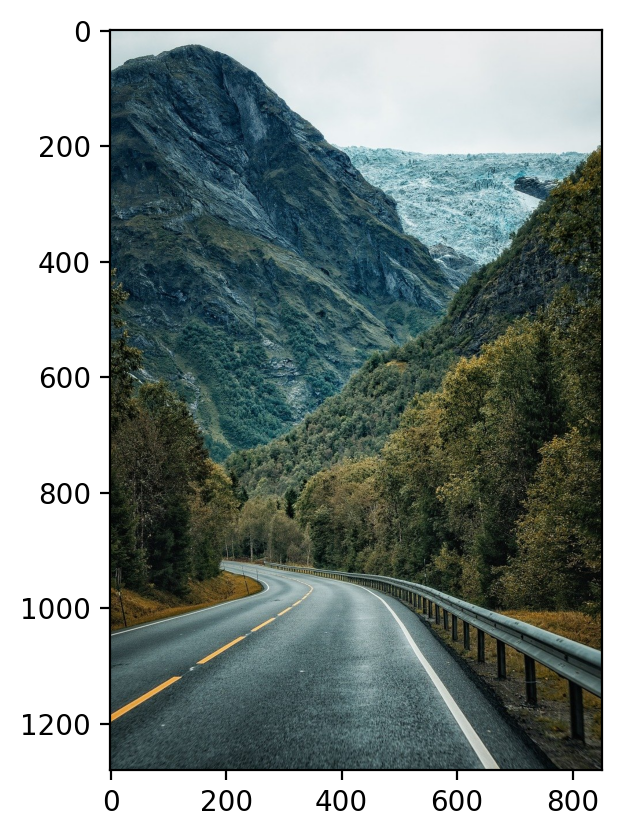

In [ ]:
if os.path.exists("/content/road-8284023_1280.jpg"):
  img = torchvision.io.read_image("/content/road-8284023_1280.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'b h w -> h w b').numpy())

In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)) #converts to 1D array of 3*h*w 3 is channels
img_scaled = img_scaled.reshape(img.shape)
img_scaled = torch.tensor(img_scaled)

cropped_image = torchvision.transforms.functional.crop(img_scaled.cpu(), 200, 400, 400, 400)
cropped_image.to(device)
cropped_image.shape

torch.Size([3, 400, 400])

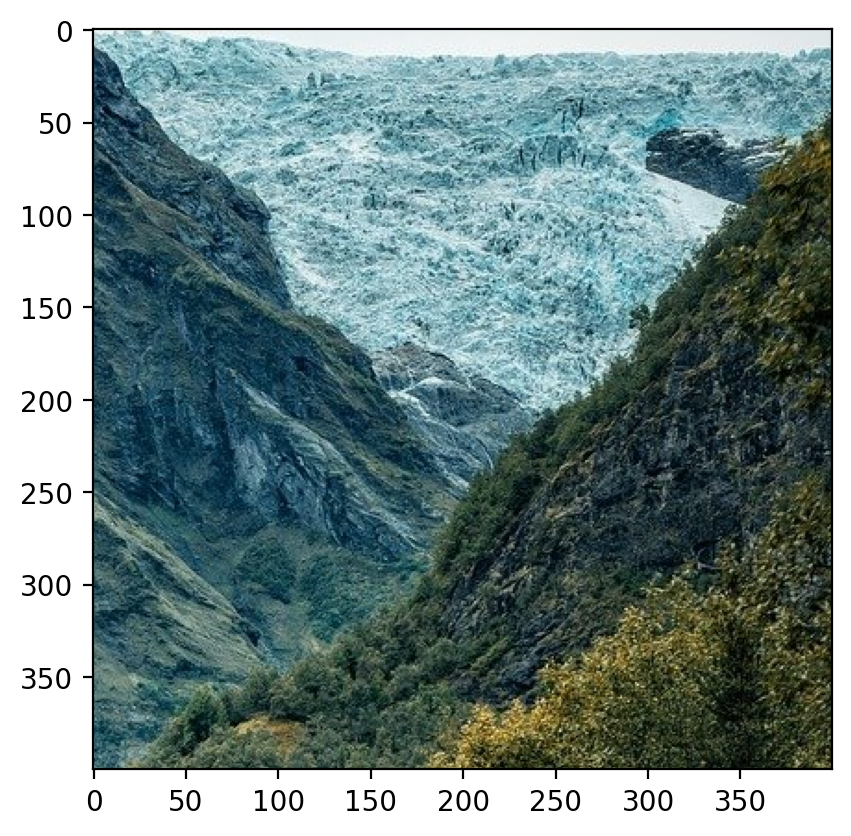

In [ ]:
plt.imshow(rearrange(cropped_image, 'c h w -> h w c').cpu().numpy())

In [ ]:
cropped_image.shape

torch.Size([3, 400, 400])

In [ ]:
import cv2
import torch
img = cropped_image.permute(1, 2, 0).numpy()  # Change (C, H, W) to (H, W, C) for OpenCV

print('Original Dimensions : ', img.shape)

# Resize the image
scale_percent = 50  # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

# Resize the image
resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
print('Resized Dimensions : ', resized.shape)

Original Dimensions :  (400, 400, 3)
Resized Dimensions :  (200, 200, 3)


In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).to(torch.float32)

    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').to(torch.float32)
    return X, Y

In [ ]:
resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
# Note: OpenCV uses (H, W, C) format, so we need to permute to (C, H, W) for PyTorch
resized = torch.from_numpy(resized).permute(2, 0, 1)  # Change from (H, W, C) to (C, H, W)
resized = resized.to(device)
print(resized.shape)  # Check the shape of the tensor

torch.Size([3, 200, 200])


In [ ]:
road_X, road_Y = create_coordinate_map(resized)
road_X_400, road_Y_400 = create_coordinate_map(cropped_image)
road_X.shape, road_Y.shape
road_Y = torch.tensor(road_Y).to(device)
road_Y_400 = torch.tensor(road_Y_400).to(device)

scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(road_X.cpu())  #road_X will work for GPU, but sklearn is for cpu
scaler_X_400 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(road_X_400.cpu())
road_X_scaled = scaler_X.transform(road_X.cpu())
road_X_scaled = torch.tensor(road_X_scaled).to(device)
road_X_400_scaled = scaler_X_400.transform(road_X_400.cpu())
road_X_400_scaled = torch.tensor(road_X_400_scaled).to(device)

# Set to dtype float32
road_X_scaled = road_X_scaled.to(torch.float32)
road_X_400_scaled = road_X_400_scaled.to(torch.float32)

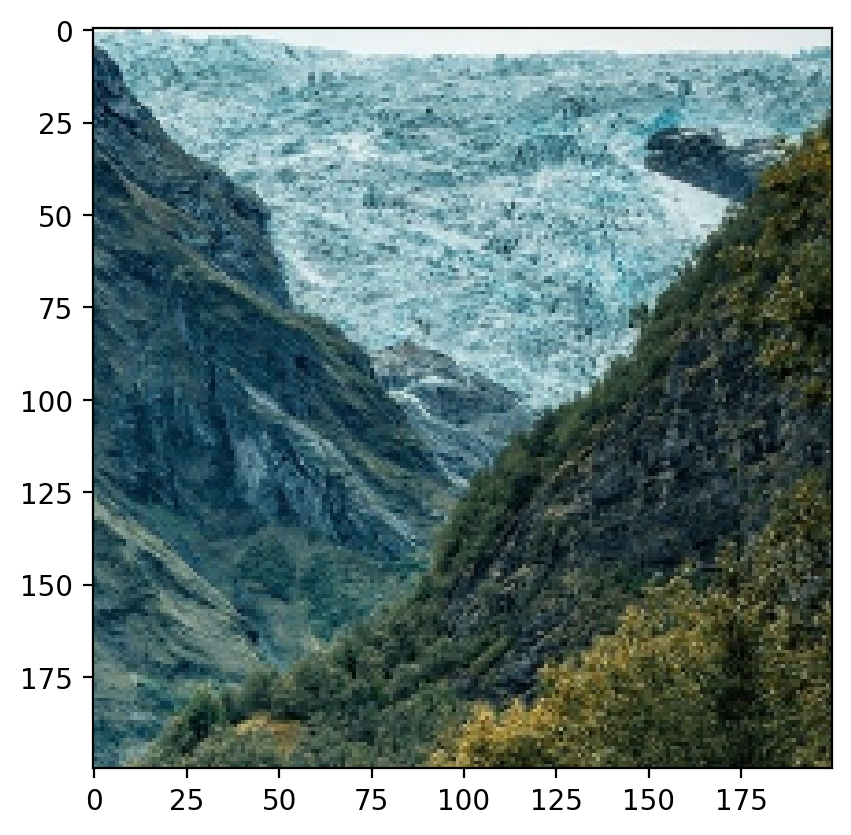

In [ ]:
plt.imshow(rearrange(resized, 'c h w -> h w c').cpu().numpy())

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    ##Now plotting for original image

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
def create_rff_features(X, num_features, sigma, device, batch_size=5000):
    X = X.to(dtype=torch.float32)  # Ensure X is float32
    n_samples, n_features = X.shape

    # Generate random weights and bias for RFF (weights can be large, so precompute and store on GPU)
    W = torch.randn(n_features, num_features, device=device, dtype=torch.float32) / sigma  # Random Gaussian weights
    b = 2 * torch.pi * torch.rand(num_features, device=device, dtype=torch.float32)  # Random bias

    Z_list = []  # Store the chunks of transformed data

    # Process the input in smaller batches to reduce memory usage
    for i in range(0, n_samples, batch_size):
        X_batch = X[i:i + batch_size]  # Slice the batch from the input tensor
        Z_batch = torch.matmul(X_batch, W) + b  # Linear transformation
        Z_batch = torch.cos(Z_batch) * (2.0 / torch.sqrt(torch.tensor(num_features, dtype=torch.float32, device=device)))  # Apply cosine and normalize
        Z_list.append(Z_batch)

    # Concatenate all the processed batches to form the final tensor
    Z = torch.cat(Z_list, dim=0)

    return Z


In [ ]:
def create_rff_features_old(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [ ]:
X_rff = create_rff_features_old(road_X_scaled, 30000, 0.005)

In [ ]:
net = LinearModel(X_rff.shape[1], 3)    #same as 2, 3 only
net.to(device)

train(net, 0.005, X_rff, road_Y, 2500)

Epoch 0 loss: 0.211455
Epoch 100 loss: 0.042164
Epoch 200 loss: 0.033136
Epoch 300 loss: 0.028891
Epoch 400 loss: 0.025757
Epoch 500 loss: 0.023263
Epoch 600 loss: 0.021186
Epoch 700 loss: 0.019407
Epoch 800 loss: 0.017852
Epoch 900 loss: 0.016477
Epoch 1000 loss: 0.015249
Epoch 1100 loss: 0.014144
Epoch 1200 loss: 0.013145
Epoch 1300 loss: 0.012236
Epoch 1400 loss: 0.011407
Epoch 1500 loss: 0.010648
Epoch 1600 loss: 0.009949
Epoch 1700 loss: 0.009305
Epoch 1800 loss: 0.008709
Epoch 1900 loss: 0.008156
Epoch 2000 loss: 0.007641
Epoch 2100 loss: 0.007161
Epoch 2200 loss: 0.006713
Epoch 2300 loss: 0.006293
Epoch 2400 loss: 0.005900


0.005534769967198372

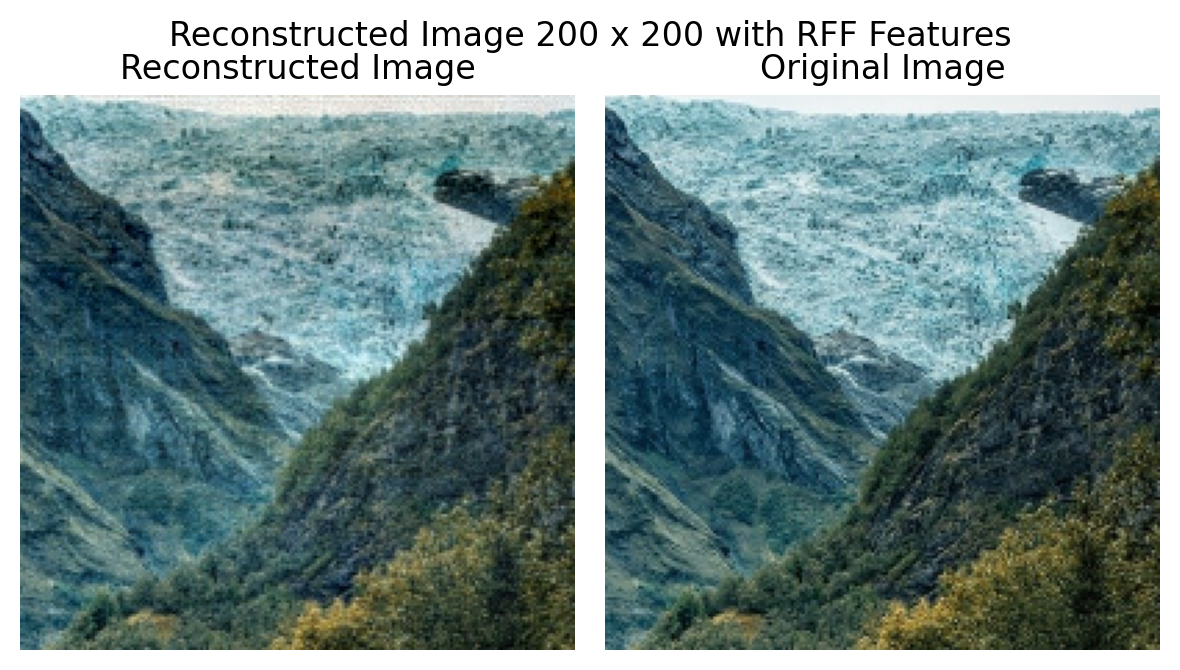

In [ ]:
plot_reconstructed_and_original_image(resized, net, X_rff, title="Reconstructed Image 200 x 200 with RFF Features")

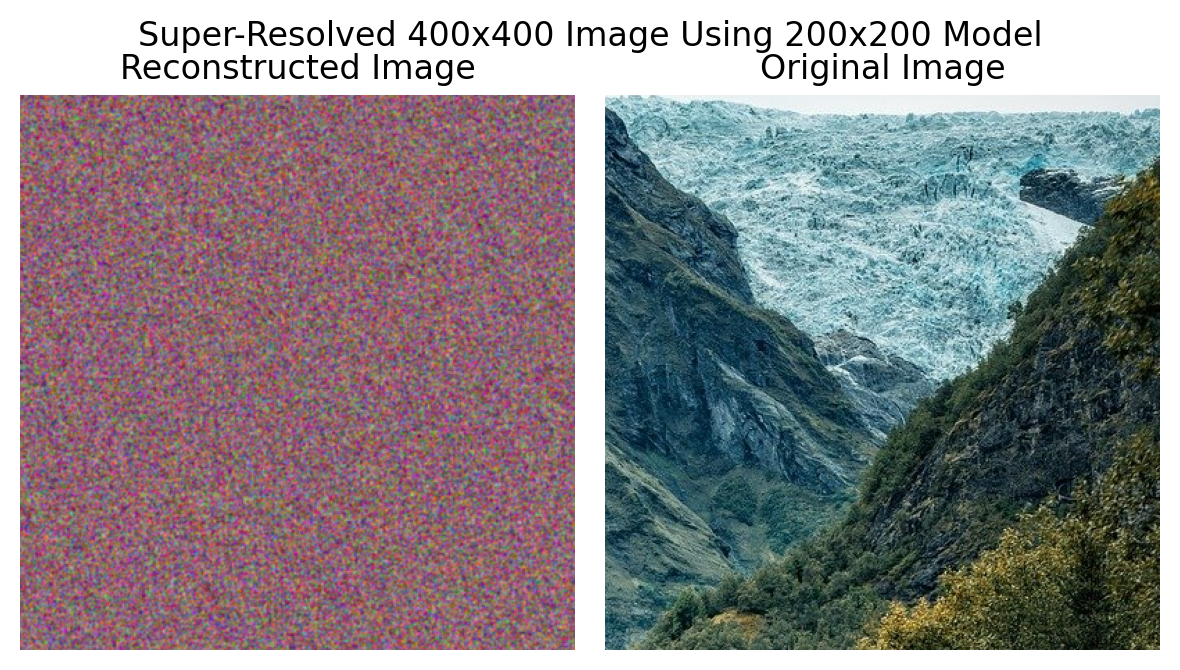

In [ ]:
# Assuming you have your previously defined functions `create_rff_features_old` and others

# Step 1: Ensure road_X_400_scaled is already created and scaled using your function

# Scale the 400x400 coordinates using the same process as for 200x200
scaler_X_400 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(road_X_400.cpu())
road_X_400_scaled = scaler_X_400.transform(road_X_400.cpu())
road_X_400_scaled = torch.tensor(road_X_400_scaled).to(device)

num_rff_features = 5000  # Choose 5000 or any other suitable number of RFF features
X_rff_400 = create_rff_features(road_X_400_scaled, num_rff_features, 0.005, device)  # Use the batch processing RFF function

# Step 3: Reinitialize the model with the new input size (matching the number of RFF features)
net = LinearModel(num_rff_features, 3)  # Adjust input size to match the RFF features generated (5000 in this case)
net.to(device)

# Step 4: Pass the RFF features through the model to reconstruct the 400x400 image
import matplotlib.gridspec as gridspec
def plot_reconstructed_and_original_image(original_img, reconstructed_img, title=""):
    """
    original_img: torch.Tensor of shape (num_channels, height, width)
    reconstructed_img: torch.Tensor of shape (num_channels, height, width)
    """
    num_channels, height, width = original_img.shape

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(reconstructed_img.cpu().permute(1, 2, 0))
    ax0.set_title("Reconstructed Image")

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    plt.show()

# Step 4: Pass the RFF features through the model to reconstruct the 400x400 image
net.eval()
with torch.no_grad():
    outputs_400 = net(X_rff_400)
    outputs_400 = outputs_400.reshape(400, 400, 3).permute(2, 0, 1)

# Normalize outputs_400 to the range [0, 1]
outputs_400 = (outputs_400 - outputs_400.min()) / (outputs_400.max() - outputs_400.min())
# Convert to [0, 255] for visualization
outputs_400 = (outputs_400 * 255).clamp(0, 255).byte()

# Plot the reconstructed and original images
plot_reconstructed_and_original_image(cropped_image, outputs_400, title="Super-Resolved 400x400 Image Using 200x200 Model")

In [ ]:
net.eval()
with torch.no_grad():
    outputs_400 = net(X_rff_400)
    outputs_400 = outputs_400.reshape(400, 400, 3).permute(2, 0, 1)

# Normalize outputs_400 to the range [0, 1]
outputs_400 = (outputs_400 - outputs_400.min()) / (outputs_400.max() - outputs_400.min())

In [ ]:
outputs_400

tensor([[[0.6309, 0.6530, 0.5411,  ..., 0.5044, 0.5795, 0.6877],
         [0.5176, 0.5365, 0.4357,  ..., 0.5472, 0.6512, 0.8008],
         [0.5290, 0.5182, 0.4329,  ..., 0.4772, 0.4987, 0.7070],
         ...,
         [0.5230, 0.6755, 0.7017,  ..., 0.5121, 0.6500, 0.6252],
         [0.5156, 0.5046, 0.4877,  ..., 0.6393, 0.7676, 0.7514],
         [0.5676, 0.4590, 0.4342,  ..., 0.5656, 0.6939, 0.6614]],

        [[0.3707, 0.0983, 0.2392,  ..., 0.4503, 0.3792, 0.3194],
         [0.3976, 0.1462, 0.2826,  ..., 0.3607, 0.3168, 0.2328],
         [0.3579, 0.2148, 0.3607,  ..., 0.4243, 0.3615, 0.3174],
         ...,
         [0.3703, 0.3654, 0.3958,  ..., 0.4658, 0.5265, 0.4748],
         [0.3060, 0.3581, 0.3764,  ..., 0.3145, 0.3816, 0.4175],
         [0.2470, 0.3853, 0.4406,  ..., 0.4093, 0.4438, 0.4687]],

        [[0.3388, 0.4013, 0.4337,  ..., 0.5325, 0.5901, 0.5829],
         [0.3308, 0.3190, 0.4149,  ..., 0.5704, 0.6084, 0.6210],
         [0.3250, 0.3054, 0.4398,  ..., 0.5892, 0.5717, 0.

In [ ]:
cropped_image

tensor([[[0.9255, 0.9255, 0.9059,  ..., 0.8706, 0.8706, 0.8706],
         [0.9647, 0.8784, 0.9569,  ..., 0.8706, 0.8706, 0.8706],
         [0.7804, 0.7529, 0.8039,  ..., 0.8706, 0.8706, 0.8706],
         ...,
         [0.3020, 0.2000, 0.3490,  ..., 0.2314, 0.5412, 0.5843],
         [0.4941, 0.2980, 0.1529,  ..., 0.4039, 0.2941, 0.5176],
         [0.1725, 0.4784, 0.3529,  ..., 0.3804, 0.2941, 0.2745]],

        [[0.9569, 0.9451, 0.9373,  ..., 0.9020, 0.9020, 0.9020],
         [1.0000, 0.9216, 1.0000,  ..., 0.9020, 0.9020, 0.9020],
         [0.8392, 0.8118, 0.8745,  ..., 0.9020, 0.9020, 0.9020],
         ...,
         [0.4471, 0.3490, 0.5098,  ..., 0.2275, 0.5255, 0.5686],
         [0.6392, 0.4510, 0.3059,  ..., 0.3922, 0.2706, 0.5020],
         [0.3176, 0.6314, 0.5059,  ..., 0.3686, 0.2745, 0.2588]],

        [[0.9686, 0.9569, 0.9490,  ..., 0.9098, 0.9098, 0.9098],
         [1.0000, 0.9373, 1.0000,  ..., 0.9098, 0.9098, 0.9098],
         [0.8667, 0.8314, 0.8902,  ..., 0.9098, 0.9098, 0.

In [ ]:
def compute_rmse(tensor1, tensor2):
    mse = torch.mean((tensor1 - tensor2) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def compute_psnr(tensor1, tensor2, max_pixel_value=1.0):
    mse = torch.mean((tensor1 - tensor2) ** 2)
    psnr = 10 * torch.log10(max_pixel_value ** 2 / mse)
    return psnr.item()

rmse = compute_rmse(cropped_image, outputs_400.cpu())
psnr = compute_psnr(cropped_image, outputs_400.cpu())

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr}")

RMSE: 0.3012806460436313
PSNR: 10.420575321157653
